# PyTorch实现的简单模型

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

## 定义神经网络函数

### 构建网络模型

In [28]:
class LogicNet(nn.Module):
    """继承nn.Module类，构建网络模型"""

    def __init__(self, inputdim, hiddendim, outputdim):
        """初始化网络结构"""
        super(LogicNet,self).__init__()
        self.Linear1 = nn.Linear(inputdim,hiddendim) #定义全连接层
        self.Linear2 = nn.Linear(hiddendim,outputdim)#定义全连接层
        self.criterion = nn.CrossEntropyLoss() #定义交叉熵函数

    def forward(self, x):
        """搭建用两层全连接组成的网络模型"""
        x = self.Linear1(x) #将输入数据传入第1层
        x = torch.tanh(x)   #对第一层的结果进行非线性变换
        x = self.Linear2(x) #再将数据传入第2层
        # print("LogicNet")
        return x

    def predict(self, x):
        """实现LogicNet类的预测接口"""
        #调用自身网络模型，并对结果进行softmax处理,分别得出预测数据属于每一类的概率
        pred = torch.softmax(self.forward(x), dim=1)
        return torch.argmax(pred, dim=1)  #返回每组预测概率中最大的索引

    def getloss(self, x, y):
        """实现LogicNet类的损失值计算接口"""
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y) #计算损失值得交叉熵
        return loss

### 可视化损失值

In [29]:
def moving_average(a, w=10):#定义函数计算移动平均损失值
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

In [30]:
def plot_losses(losses):
    avgloss= moving_average(losses) #获得损失值的移动平均值
    plt.figure(1)
    plt.subplot(211)
    plt.plot(range(len(avgloss)), avgloss, 'b--')
    plt.xlabel('step number')
    plt.ylabel('Training loss')
    plt.title('step number vs. Training loss')
    plt.show()

### 预测函数

In [32]:
def predict(model, x):   #封装支持Numpy的预测接口
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.predict(x)
    return ans.numpy()

### 可视化模型边界

In [34]:
def plot_decision_boundary(pred_func, X, Y):
    """在直角坐标系中可视化模型能力"""
    #计算取值范围
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    #在坐标系中采用数据，生成网格矩阵，用于输入模型
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #将数据输入并进行预测
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #将预测的结果可视化
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.title("Linear predict")
    arg = np.squeeze(np.argwhere(Y==0),axis = 1)
    arg2 = np.squeeze(np.argwhere(Y==1),axis = 1)
    plt.scatter(X[arg,0], X[arg,1], s=100,c='b',marker='+')
    plt.scatter(X[arg2,0], X[arg2,1],s=40, c='r',marker='o')
    plt.show()

## 分析数据集

这是类似太极图的相互缠绕的两组数据。

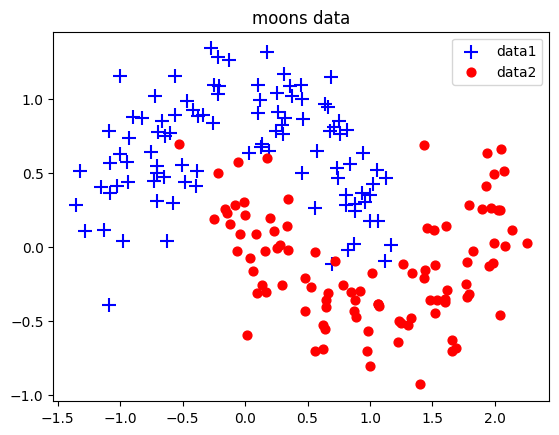

In [27]:
import sklearn.datasets     #引入数据集
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)           #设置随机数种子
X, Y = sklearn.datasets.make_moons(200, noise=0.2) #生成2组半圆形数据

arg1 = np.squeeze(np.argwhere(Y==0), axis=1)     #获取第1组数据索引
arg2 = np.squeeze(np.argwhere(Y==1), axis=1)    #获取第2组数据索引

plt.title("moons data")
plt.scatter(X[arg1,0], X[arg1,1], s=100,c='b', marker='+', label='data1')
plt.scatter(X[arg2,0], X[arg2,1], s=40, c='r', marker='o', label='data2')
plt.legend()
plt.show()

### 模型训练

- 神经网络模型：2 x 3 x 2
- 优化器：Adam
- epochs：1000轮

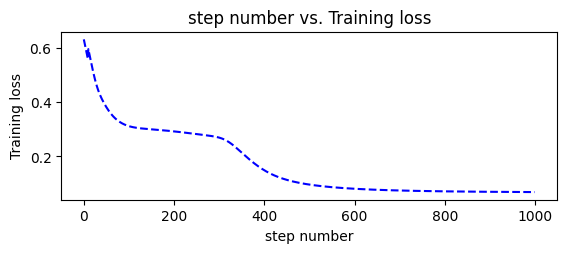

In [35]:
model = LogicNet(inputdim=2,hiddendim=3,outputdim=2)#初始化模型
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#定义优化器

xt = torch.from_numpy(X).type(torch.FloatTensor)#将Numpy数据转化为张量
yt = torch.from_numpy(Y).type(torch.LongTensor)
epochs = 1000 #定义迭代次数
losses = []   #定义列表，用于接收每一步的损失值

for i in range(epochs):
    loss = model.getloss(xt, yt)
    losses.append(loss.item())
    optimizer.zero_grad()#清空之前的梯度
    loss.backward()#反向传播损失值
    optimizer.step()#更新参数

plot_losses(losses)

0.975


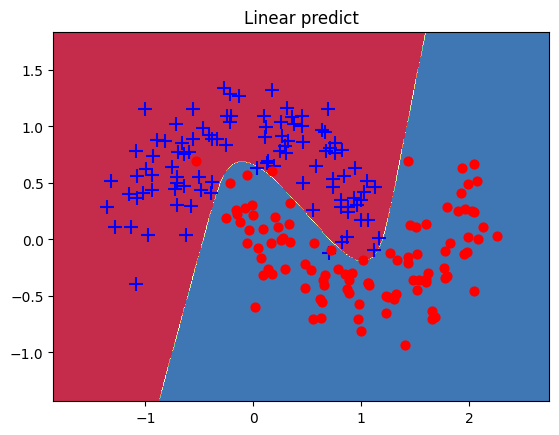

In [36]:
from sklearn.metrics import accuracy_score
print(accuracy_score(model.predict(xt),yt))

plot_decision_boundary(lambda x : predict(model,x) ,xt.numpy(), yt.numpy())